# Question 1

Files are first 11 lines that present the initial parameters there is one line by obstacles which is represented by 4 numbers.
One can first check that the file is made of at least 11 lines consisting of only one number, then check than any further line is made of group of 4 and finaly that coordinates belong to (0,O, xmin, xmax)


In [347]:
def parse(filename : str):
    '''
    Takes a filename and return a list of :
    5 tupple (x_max, y_max) , u_s1, u_d1, u_s2, u_d2
    a float R
    and a list of obstacles which are represented by a tupple (xo,yo,ℓx,ℓy )
    elements by obstacle
    '''
    with open(filename, "r") as f:
        lines = f.readlines() 

    ## check that f is well defined
    if (len(lines)) < 11: # f must contain at least 11 lines
        raise ValueError("Invalid input")
    for line in lines:
        line = line.strip()

    for line in lines[0:11]:
        try:
            (line) = float(line)
        except ValueError:
            raise ValueError("Invalid input")
    for line in lines[11:]:
        line = line.split()
        if len(line) != 4:
            raise ValueError("Invalid input")
        for number in line:
            try:
                (number) = float(number)
            except ValueError:
                raise ValueError("Invalid input")
    # we know that f is well structured we can now parse it
    coordinates_max = (float(lines[0]), float(lines[1]))
    u_s1 = (float(lines[2]), float(lines[3]))
    u_d1 = (float(lines[4]), float(lines[5]))
    u_s2 = (float(lines[6]), float(lines[7]))
    u_d2 = (float(lines[8]), float(lines[9]))

    R = float(lines[10])

    obstacles : list[tuple[float]] = []
    for line in lines[11::]:
        line = line.split()
        obstacles.append(tuple(float(x) for x in line))

    return [coordinates_max, u_s1, u_d1, u_s2, u_d2, R, obstacles]




In [348]:
filename_test :str = "scenarios/scenario1.txt"
parsed = parse(filename_test)

# Question 2

In [349]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as mlines
from matplotlib.axes import Axes
from matplotlib.figure import Figure

OUTLINE_COLOR = "red"
FILL_COLOR = "black"
WHITE = (255, 255, 255, 0)

def create_image(dimension : tuple[float, float]):
    fig, ax  = plt.subplots(figsize = (10, 10))
    ax.set_xlim(0, dimension[0])
    ax.set_ylim(0, dimension[1])

    return fig, ax


def print_obstacle(obstacle : tuple[float, float, float, float],  ax : Axes):
    rect = patches.Rectangle(
        (obstacle[0], obstacle[1]),  
        obstacle[2],                 
        obstacle[3],                
        facecolor=FILL_COLOR,
        edgecolor=OUTLINE_COLOR
    )
    

    ax.add_patch(rect)

def print_vertex(departure : tuple[float, float], arrive : tuple[float, float], ax : Axes):
    x_coords = [departure[0], arrive[0]]
    y_coords = [departure[1], arrive[1]]
    
    line = mlines.Line2D(x_coords, y_coords, color=OUTLINE_COLOR, linewidth=3)
    ax.add_line(line)
    ax.scatter(departure[0], departure[1], s=50, c='blue', zorder=3)

def print_obstacles(obstacles: list[tuple[float, float, float, float]], ax: Axes):
    for obstacle in obstacles:
        print_obstacle(obstacle, ax)

def print_path(vertices: list[list[tuple[float, float]]], ax: Axes):
    for vertex_pair in vertices:
        print_vertex(vertex_pair[0], vertex_pair[1], ax)



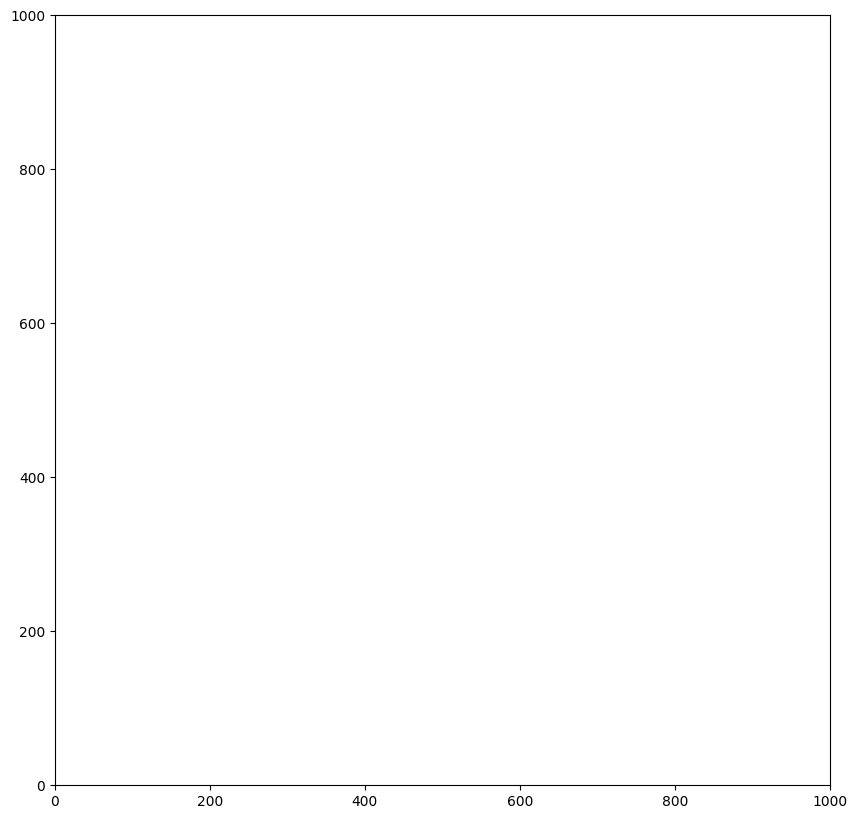

In [350]:

coordinates_max, u_s1, u_d1, u_s2, u_d2, R, obstacles = parsed
fig,ax = create_image(coordinates_max)

In [351]:
print_obstacles(obstacles, ax)


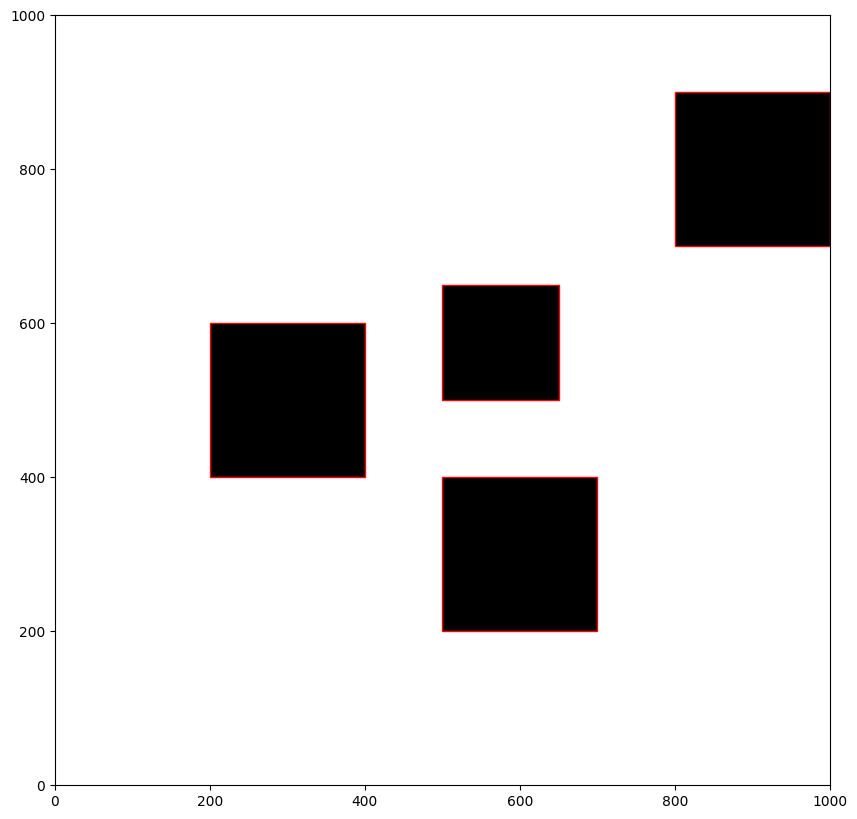

In [352]:
display(fig)

# Question 3

Dans notre problème, une particule correspond à un test de chemin et la fonction fitness pourrait être l'écart en vol d'oiseau à l'arrivé.
On peut envisager différentes structures de données, mais afin d'avoir un maximum de particules et de pouvoir parraléliser les calculs le plus efficace serait d'utiliser 3 arrays différents contenants positions, vitesses, meilleur minima local.
Afin de pouvoir à la fin regarder le meilleur chemin il faut stocker toutes les positions,
le premier array peut donc être une table (nombre de particule) x (nombre d'itération)

# Question 4 
On peut pour chaque arrête sur le graphe tester si elle collisione avec chaque arrete des rectangles 

In [353]:
def check_collision_path(path : list[list[tuple[float, float]]], obstacles : list[tuple[float, float, float, float]]):
    for obstacle in obstacles:
        for vertex in path:
            if check_collision_vertex_obstacle(vertex, obstacle):
                return True
    return False

def check_collision_vertex_obstacle(vertex : list[tuple[float, float]], obstacle : tuple[float, float, float, float]):
    x0, y0 = vertex[0]
    x1, y1 = vertex[1]
    # let's find the intersection by computing the direction of the segment
    # y = a*x + b
    vertical = False
    if x1 != x0:
        a = (y1 - y0)/(x1 - x0)
        b = y1 - a*x1
    else:
        vertical = True
    
    
    #we need to deconstruct the obstacle too
    lower_left_x = obstacle[0]
    lower_left_y = obstacle[1]
    width = obstacle[2]
    height = obstacle[3]

    # treat the case where the line is verticale or a = 0 cause
    # there might not be intersection  

    if not vertical and  a == 0:
        # check with the verticale part of the square
        if b >= lower_left_y and b <= lower_left_y + height:
            #there is 3 scenario the vertex is completly in the rectangle
            #no need to say true as a previous check would have said true
            #first point is out and the second inside or vice-versa
            if (x1 < lower_left_x and x0 > lower_left_x) \
                or (x1 <= lower_left_x + width and x0 >= lower_left_x + width)\
                or (x0 <= lower_left_x and x1 >= lower_left_x) \
                or (x0 <= lower_left_x + width and x1 >= lower_left_x + width):
                return True
            
    elif vertical:
        x = x0
        if x >= lower_left_x and x <= lower_left_x + width:
            if (y0 <= lower_left_y) and (y1 >= lower_left_y )\
                or (y0 <= lower_left_y + height) and (y1 >= lower_left_y + height)\
                or (y1 <= lower_left_y) and (y0 >= lower_left_y )\
                or (y1 <= lower_left_y + height) and (y0 >= lower_left_y + height):
                return True
    else:
        # let's compute the four point of intersection and check if inside the segment
        for b1 in [lower_left_y, lower_left_y + height]:
            to_check = (b1 - b)/a
            if ((to_check >= x0 and to_check <= x1) or\
                (to_check >= x1 and to_check <= x0)) and (to_check >= lower_left_x and to_check <= lower_left_x + width):
                return True
        y_1_to_check = a*lower_left_x + b
        y_2_to_check = a*(lower_left_x + width)+ b
        for to_check in [y_1_to_check, y_2_to_check]:
            if ((to_check >= lower_left_y and to_check <= lower_left_y + height)) and\
                (to_check >= min(y0, y1) and to_check <= max(y0, y1)):
                return True
                



In [354]:
# test written with AI
def run_tests():
    obs = [(2.0, 2.0, 4.0, 4.0)]
    
    tests = [
        {
            "desc": "Basic: No Collision (Far away)",
            "path": [[(0.0, 0.0), (1.0, 1.0)]],
            "expect": False
        },
        {
            "desc": "Basic: Simple Intersection",
            "path": [[(1.0, 4.0), (7.0, 4.0)]],
            "expect": True
        },
        {
            "desc": "Horizontal Aligned (Ghost Floor)",
            # Line is at y=4 (middle of box) but to the right (x=8 to 10)
            "path": [[(8.0, 4.0), (10.0, 4.0)]],
            "expect": False
        },
        {
            "desc": " Vertical Aligned (Laser Pointer)",
            # Line is at x=4 (middle of box) but above (y=8 to 10)
            "path": [[(4.0, 8.0), (4.0, 10.0)]],
            "expect": False
        },
        {
            "desc": "Sloped Pointing At Wall",
            # Points at (2,2) but stops at (1,1)
            "path": [[(0.0, 0.0), (1.0, 1.0)]],
            "expect": False
        },
        {
            "desc": "Edge Case: Exact Corner Touch",
            "path": [[(0.0, 0.0), (2.0, 2.0)]],
            "expect": True
        },
        {
            "desc": "Complex: Long diagonal crossing entire box",
            "path": [[(0.0, 0.0), (10.0, 10.0)]],
            "expect": True
        }
    ]

    print(f"{'TEST CASE':<50} | {'RESULT':<6}")
    print("-" * 60)
    
    all_passed = True
    for t in tests:
        result = check_collision_path(t['path'], obs)
        status = "PASS" if result == t['expect'] else "FAIL"
        if status == "FAIL": all_passed = False
        print(f"{t['desc']:<50} | {status} (Got {result})")
    
    print("-" * 60)
    if all_passed:
        print("ALL TESTS PASSED")
    else:
        print("SOME TESTS FAILED")


run_tests()

TEST CASE                                          | RESULT
------------------------------------------------------------
Basic: No Collision (Far away)                     | PASS (Got False)
Basic: Simple Intersection                         | PASS (Got True)
Horizontal Aligned (Ghost Floor)                   | PASS (Got False)
 Vertical Aligned (Laser Pointer)                  | PASS (Got False)
Sloped Pointing At Wall                            | PASS (Got False)
Edge Case: Exact Corner Touch                      | PASS (Got True)
Complex: Long diagonal crossing entire box         | PASS (Got True)
------------------------------------------------------------
ALL TESTS PASSED


# Question 5

On va réaliser pour un nombre fixer à l'avance d'itération le shéma suivant
 1) Actualiser les position
 2) Tester si on rencontre un mur
 3) Recalculer les valeurs nécessaires
 
A la fin, garde les path qui sont arrivé à une distance epsilon de l'arrivé
On coupe chaque path à la première fois qu'il sont suffisament proche de l'arrivé
On calcule le chemin le plus cours

# Question 6

On note P le nombre de particule et N le nombre d'itération.
Chaque itération de la boucle est en O(P), effectué toute les boucles est dont en O(NP)
Puis vérifier un path et calculer la distance parcouru est en O(N), pour tout les path donc en O(NP)
L'algorithme pris dans son ensemble est donc en O(NP)

# Question 7

In [ ]:
import numpy as np

def fitness_func(pos, xf, yf):
    '''
    Calculate squared Euclidean distance for the whole swarm at once.
    pos: shape (N, 2)
    xf, yf: coordinates of the target
    '''
    # Sum of squared differences along axis 1 (x and y)
    return np.sum((pos - np.array([xf, yf]))**2, axis=1)

# --- Hyper parameters ---
w = 0.95
c1 = 0.9
c2 = 0.9
low_init = 0
high_init = 10
xf = u_d1[0]
yf = u_d2[1]

iterations = 100000
particles_number = 1000

#Initialization
positions = np.zeros((particles_number, iterations, 2))

positions[:, 0, :] = np.random.uniform(low=low_init, high=high_init, size=(particles_number, 2)) + np.array(u_s1)

# Initialize Velocity 
speed = np.zeros((particles_number, 2)) 

#Initialize bests
pbest_pos = positions[:, 0, :].copy()
pbest_val = fitness_func(pbest_pos, xf, yf)

# Global Best 
gbest_index = np.argmin(pbest_val)
gbest_pos = pbest_pos[gbest_index].copy()
gbest_val = pbest_val[gbest_index]

for t in range(iterations - 1):
    current_pos = positions[:, t, :]
    
    # 1. Draw random numbers (r1, r2)
    r1 = np.random.uniform(0, 1, (particles_number, 2))
    r2 = np.random.uniform(0, 1, (particles_number, 2))

    # 2. Update Velocity
    acceleration = c1 * r1 * (pbest_pos - current_pos) +  c2 * r2 * (gbest_pos - current_pos)  
    speed = w * speed + acceleration

    # 3. Update Position
    new_pos = current_pos + speed
    positions[:, t + 1, :] = new_pos

  
    for i in range(particles_number):
        for obstacle in obstacles:
            if check_collision_vertex_obstacle([tuple(current_pos[i]), tuple(new_pos[i])], obstacle):
                positions[i, t+1, :] = current_pos[i] 
                break
            if current_pos[i][0] > coordinates_max[0] or current_pos[i][0] < 0\
            or current_pos[i][1] > coordinates_max[1] or current_pos[i][1] < 0:
                positions[i, t+1, :] = current_pos[i] 
                
            
    # 4. Evaluate Fitness
    current_fitness = fitness_func(positions[:, t + 1, :], xf, yf)

    # 5. Update Personal Bests 
    improved_indices = current_fitness < pbest_val
    pbest_pos[improved_indices] = positions[improved_indices, t + 1, :]
    pbest_val[improved_indices] = current_fitness[improved_indices]

    # 6. Update Global Best 
    current_min_val = np.min(current_fitness)
    if current_min_val < gbest_val:
        gbest_val = current_min_val
        gbest_index = np.argmin(current_fitness)
        gbest_pos = positions[gbest_index, t + 1, :].copy()

# Compute results
epsilon = 2

deltas = positions[:, 1 : iterations , :] - positions[:, 0 : iterations -1, :]
deltas = np.sum(deltas**2, axis=2)
deltas = np.sqrt(deltas)


valid = (positions - np.array([xf, yf]))**2
valid = np.sum(valid, axis=2)
valid = valid < epsilon
argmin = np.argmax(valid, axis=1) - 1 # to get the first point of hit
indices = np.arange(deltas.shape[1])
masks = indices < argmin[:, None]
deltas = deltas * masks
valid = np.any(valid, axis = 1)
path_length = np.sum(deltas, axis = 1)
path_length = valid * path_length + (1 - valid) * np.inf
min_length = np.min(path_length)
min_index = np.argmin(path_length)
print(f"Best path is the {min_index} with a total length of {min_length}")



Best path is the 0 with a total length of inf


In [356]:
print(positions[0, :, :])

[[  4.0397467    8.82977015]
 [  6.91091157   8.90122726]
 [ 10.57275969   8.97085807]
 ...
 [487.07714857 271.99718582]
 [487.07714857 271.99718582]
 [487.07714857 271.99718582]]


In [357]:
def from_array_to_path(points):
    return [[tuple(points[i]), tuple(points[i+1])] for i in range(points.shape[0] - 1)]

print_path(from_array_to_path(positions[3, :, :]), ax)

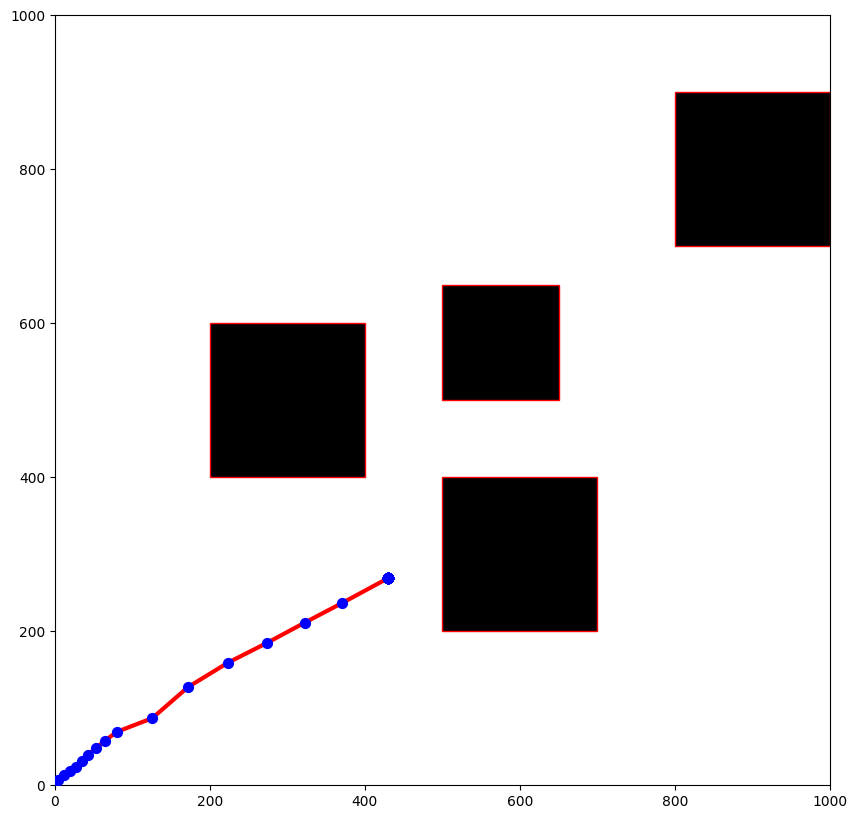

In [358]:
display(fig)

In [359]:
print(u_s1)


(0.0, 0.0)
